### Setup Models

In [9]:
# LLM packages
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

# Agentic AI packages
from langchain_core.tools import tool
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain.document_loaders import PyPDFLoader

# LangGraph packges
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

import pandas as pd
import os
from typing import TypedDict, Annotated
import operator
from IPython.display import Image
import json
import uuid
from dotenv import load_dotenv
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')



In [2]:
# Start the LLM and embeddings
model = ChatOpenAI(
    model = "gpt-4o",
    openai_api_key = OPENAI_API_KEY
)

embedding = OpenAIEmbeddings(
    model = "text-embedding-3-large",
)

### Engineered Prompts

In [3]:
summarizer_prompt="""
You are an document summarizer who can summarize a document provide to you.
For the input provided, create a summary with less than 50 words.
If the user has provides critique, responsed with a revised version of your previous attempts
"""

reviewer_prompt="""
You are a reviewer grading summaries for an article. 
Compare the user input document and generated summary.
Check if the summary accurately reflects the contents of the document.
Provide recommendations for improvement in less than 50 words.
"""

### Setup the summary-with-review agent

#### Define the Agent State

In [5]:
class SummaryAgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

#### Define the Reflection Agent

In [6]:
class SummaryAgent:
    def __init__(self, model, summarizer_prompt, reviewer_prompt, debug = False):
        # get all the parms
        self.model = model
        self.summarizer_prompt = summarizer_prompt
        self.reviewer_prompt = reviewer_prompt
        self.debug = debug

        # Build the nodes of the graph
        summary_agent_graph = StateGraph(SummaryAgentState)
        summary_agent_graph.add_node("summarizer", self.generate_summary)
        summary_agent_graph.add_node("reviewer", self.review_summary)
        # Build edges of the graph
        summary_agent_graph.add_conditional_edges(
            "summarizer",
            self.should_continue,
            {True:"reviewer", False: END}
        )
        summary_agent_graph.add_edge("reviewer","summarizer")
        # Set Graph entry point
        summary_agent_graph.set_entry_point("summarizer")
        # Add chat memory
        self.memory = MemorySaver()
        # Compile the graph
        self.summary_agent_graph = summary_agent_graph.compile(checkpointer=self.memory)

    # LLM Node for Summarizer
    def generate_summary(self, state: SummaryAgentState)-> dict:
        messages = state["messages"]

        # Prepend summarizer system prompt to messages
        messages = [SystemMessage(content=self.summarizer_prompt)] + messages

        # Invoke the summarizer with the message history
        result = self.model.invoke(messages)

        if self.debug:
            print(f"=================\n Summarizer returned output: {result.content}")
        
        return {"messages":[result]}
    

    # LLM Node for reviewer
    def review_summary(self, state:SummaryAgentState)-> dict:
        messages=state["messages"]

        # Prepend Reviewer system prompt to messages
        messages = [SystemMessage(content=self.reviewer_prompt)] + messages

        # Invoke the reviewer with the message history
        result = self.model.invoke(messages)

        if self.debug:
            print(f"******************\n Reviewer returned output: {result.content}")
        
        return {"messages": [result]}
    
    # Decide if max iterations have been reached or not
    def should_continue(self, state: SummaryAgentState):
        total_reviews = len(state["messages"]) /2

        if self.debug:
            print(f"Iteration Number: {total_reviews}")
        
        # Breakout of the iteration loop if 2 iterations are done
        if len(state["messages"]) > 4:
            return False
        else:
            return True

### Setup the agentic system

In [7]:
# Setup the summary bot
summary_chatbot = SummaryAgent(
    model=model,
    summarizer_prompt=summarizer_prompt,
    reviewer_prompt=reviewer_prompt,
    debug=True
)

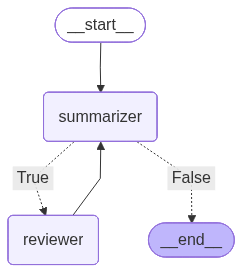

In [8]:
Image(summary_chatbot.summary_agent_graph.get_graph().draw_mermaid_png())

#### Load the document

In [11]:
loader = PyPDFLoader("..//data//EcoSprint_Specification_Document.pdf")
docs = loader.load()

### Execute the agent

In [12]:
config = {"configurable": {"thread_id": str(uuid.uuid4())}}
source_content=docs[0].page_content.replace("\n"," ")

messages = [HumanMessage(content=source_content)]
result=summary_chatbot.summary_agent_graph.invoke({"messages":messages},config)

 Summarizer returned output: The EcoSprint is a cutting-edge electric vehicle designed for efficiency and performance, appealing to eco-conscious drivers who value style and experience. It features a modern design, spacious interior, powerful electric motor, impressive range, advanced infotainment and safety systems, and convenient connectivity options.
Iteration Number: 1.0
******************
 Reviewer returned output: The summary accurately reflects the document's main points. However, consider mentioning specific design features like color options and interior luxury elements for a more comprehensive overview. Including specific performance metrics such as acceleration and top speed could also enhance the summary's detail.
 Summarizer returned output: The EcoSprint is a groundbreaking electric vehicle combining efficiency, style, and advanced technology. It features a sleek design, luxurious interior, powerful motor, and impressive range. Equipped with state-of-the-art infotainment,

#### Execution with Human for feedback in loop

In [13]:
#Take user feedback on the summary through a chatbot
summary_chatbot = SummaryAgent(model, 
                               summarizer_prompt, 
                               reviewer_prompt,
                               debug=False)


user_inputs = [
    source_content,
    "Can you rewrite the review by focusing more on the specifications?",
    "Can you remove details about the touchscreen?"
]

#Create a new thread
config = {"configurable": {"thread_id": "thread-summarizer"}}

#Given the number of iterations, this will take a long time.
for input in user_inputs:
    print(f"----------------------------------------\nUSER : {input}")
    #Format the user message
    user_message = {"messages":[HumanMessage(input)]}
    #Get response from the agent
    ai_response = summary_chatbot.summary_agent_graph.invoke(user_message,config=config)
    #Print the response
    print(f"\nAGENT : {ai_response['messages'][-1].content}")

----------------------------------------
USER : EcoSprint SpecificationDocument 1.Overview● TheEcoSprint isarevolutionaryelectricvehicle(EV)designedforefficiencyandperformance. Withitssleekdesignandstate-of-the-art technology, theEcoSprintappealstoenvironmentallyconsciousdriverswhodon't want tocompromiseonstyleordrivingexperience. Ideal forcitydrivinganddailycommutes, theEcoSprint offersaperfect blendof comfort, sustainability, andinnovation. 2.DesignSpecifications● ExteriorDesign: TheEcoSprint boastsamodernandaerodynamicsilhouette, featuringsmoothlinesandacompact formfactor. AvailableincolorslikeMidnight Black, OceanBlue, andPearl White, it'sahead-turnerontheroad.● InteriorDesign: Inside, theEcoSprint isarealmof comfort andluxury. It offersaspaciouscabinwithseatingforfive, premiumupholstery, andcustomizableambientlighting. 3.PerformanceSpecifications● EngineandMotor: Poweredbyahigh-efficiencyelectricmotor, theEcoSprint delivers200horsepowerand300Nmof torque, providingasmoothandrespons